In [11]:
# load all fixed points relative to P_150
from pathlib import Path
import numpy as np
import pandas as pd
from collections import defaultdict

import sys
sys.path.append("../")
from nnperm.perm import PermutationSpec

model_path = Path("../refactor-outputs/sparse-sparse-perms/")


def recover_matrix_from_triu(flat_list, n):
    idx_a, idx_b = np.triu_indices(n)
    sq_matrix = np.zeros([n, n])
    for i, (a, b) in enumerate(zip(idx_a, idx_b)):
        sq_matrix[a, b] = flat_list[i]
        sq_matrix[b, a] = flat_list[i]
    return sq_matrix

df = []
perm_files = {}
sizes = {}
fps = defaultdict(list)
averaged_fps = {}
fixed_points = np.load(model_path / "fixed_points_summary.npz")
perm_files = fixed_points["perms"]
# get index of P_150
p_150_idx = [i for i, x in enumerate(perm_files) if "level_0" in x]
assert len(p_150_idx) == 1
p_150_idx = p_150_idx[0]
for layer_idx, (layer, flat_list) in enumerate(fixed_points.items()):
    if layer != "perms":
        fp = recover_matrix_from_triu(flat_list, len(perm_files))
        fps[layer].append(fp)
        for k, v in zip(perm_files, fp[p_150_idx]):
            df.append({
                "path": k,
                "layer": layer_idx,
                "fixed_points": v,
            })
fps = {k: np.mean(np.stack(v, axis=0), axis=0) for k, v in fps.items()}
perm, perm_spec = PermutationSpec.load_from_file(next(model_path.rglob("perm*.pt")))
sizes = {k: len(v) for k, v in perm.items()}
# get mean of fixed points weighted by number of channels
total_fixed_points = np.sum(np.stack([v * sizes[k] for k, v in fps.items()], axis=0), axis=0)
n_positions = np.sum(list(sizes.values()))
averaged_fps = total_fixed_points / n_positions
for k, v in zip(perm_files, averaged_fps[p_150_idx]):
    df.append({
        "path": k,
        "layer": None,
        "fixed_points": v,
    })
df = pd.DataFrame(df)

In [20]:
# get model name, perm epoch, threshold, etc.
layer_idx_to_depth = {
    "cifar_vgg_16_64": {
        "0": 1,
        "1": 2,
        "3": 3,
        "4": 4,
        "6": 5,
        "7": 6,
        "8": 7,
        "10": 8,
        "11": 9,
        "12": 10,
        "14": 11,
        "15": 12,
        "16": 13,
        "fc": 14,
    },
    "cifar_resnet_20_64": {
        "0": 2,
        "1": 3,
        "2": 4,
        "3": 5,
        "4": 6,
        "5": 7,
        "6": 8,
        "7": 9,
        "8": 10,
        "fc": 11,
    }
}


def first_matching_substr(string, delimiter, starts=[""], strip=False):
    for part in string.split(delimiter):
        if not isinstance(starts, list):
            starts = [starts]
        for start in starts:
            if part.startswith(start):
                return part[len(start):] if strip else part
    return None

def to_int_if_exists(string):
    try:
        return int(string)
    except:
        return None

def convert_column_to_epoch(df, column):
    df[column + ".epoch"] = df[column].apply(
        lambda x: to_int_if_exists(first_matching_substr(x, "_", "ep", True)))

def get_all_thresholds(dataframe):
    depths = []
    for i, row in dataframe.iterrows():
        depth = layer_idx_to_depth[row["model.name"]].get(row["threshold"], None)
        depths.append(depth)
    return depths

df["level"] = df["path"].apply(lambda x: int(x.split("-")[-2].split("level_")[1]))

df

,path,layer,fixed_points,level,perm,model,model.name,replicate,layersplit_type,threshold
0,/home/mila/d/devin.kwok/scratch/2022-nnperm/sp...,0.0,1.000000,0,None,None,None,None,lottery_45792df32ad68649ffd066ae40be4868-repli...,main
1,/home/mila/d/devin.kwok/scratch/2022-nnperm/sp...,0.0,0.421875,10,None,None,None,None,lottery_45792df32ad68649ffd066ae40be4868-repli...,main
2,/home/mila/d/devin.kwok/scratch/2022-nnperm/sp...,0.0,0.390625,11,None,None,None,None,lottery_45792df32ad68649ffd066ae40be4868-repli...,main
3,/home/mila/d/devin.kwok/scratch/2022-nnperm/sp...,0.0,0.468750,12,None,None,None,None,lottery_45792df32ad68649ffd066ae40be4868-repli...,main
4,/home/mila/d/devin.kwok/scratch/2022-nnperm/sp...,0.0,0.390625,13,None,None,None,None,lottery_45792df32ad68649ffd066ae40be4868-repli...,main
...,...,...,...,...,...,...,...,...,...,...
289,/home/mila/d/devin.kwok/scratch/2022-nnperm/sp...,NaN,0.183475,5,None,None,None,None,lottery_45792df32ad68649ffd066ae40be4868-repli...,main
290,/home/mila/d/devin.kwok/scratch/2022-nnperm/sp...,NaN,0.180398,6,None,None,None,None,lottery_45792df32ad68649ffd066ae40be4868-repli...,main
291,/home/mila/d/devin.kwok/scratch/2022-nnperm/sp...,NaN,0.162169,7,None,None,None,None,lottery_45792df32ad68649ffd066ae40be4868-repli...,main
292,/home/mila/d/devin.kwok/scratch/2022-nnperm/sp...,NaN,0.151278,8,None,None,None,None,lottery_45792df32ad68649ffd066ae40be4868-repli...,main


In [21]:
# plotting code
import matplotlib.pyplot as plt
import seaborn as sns

def finalize_plot(fig, shape=(1, 1)):
    plt.gcf().set_size_inches(
        shape[0] * 1. * plt.gcf().get_size_inches()[1], 
        shape[1] * 1. * plt.gcf().get_size_inches()[1])
    fig.tight_layout()
    plt.legend()
    return fig

sns.set(font_scale=1.3)
sns.set_style("darkgrid", {"axes.facecolor": ".95"})

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


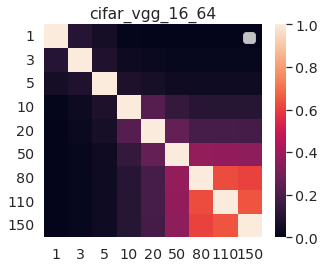

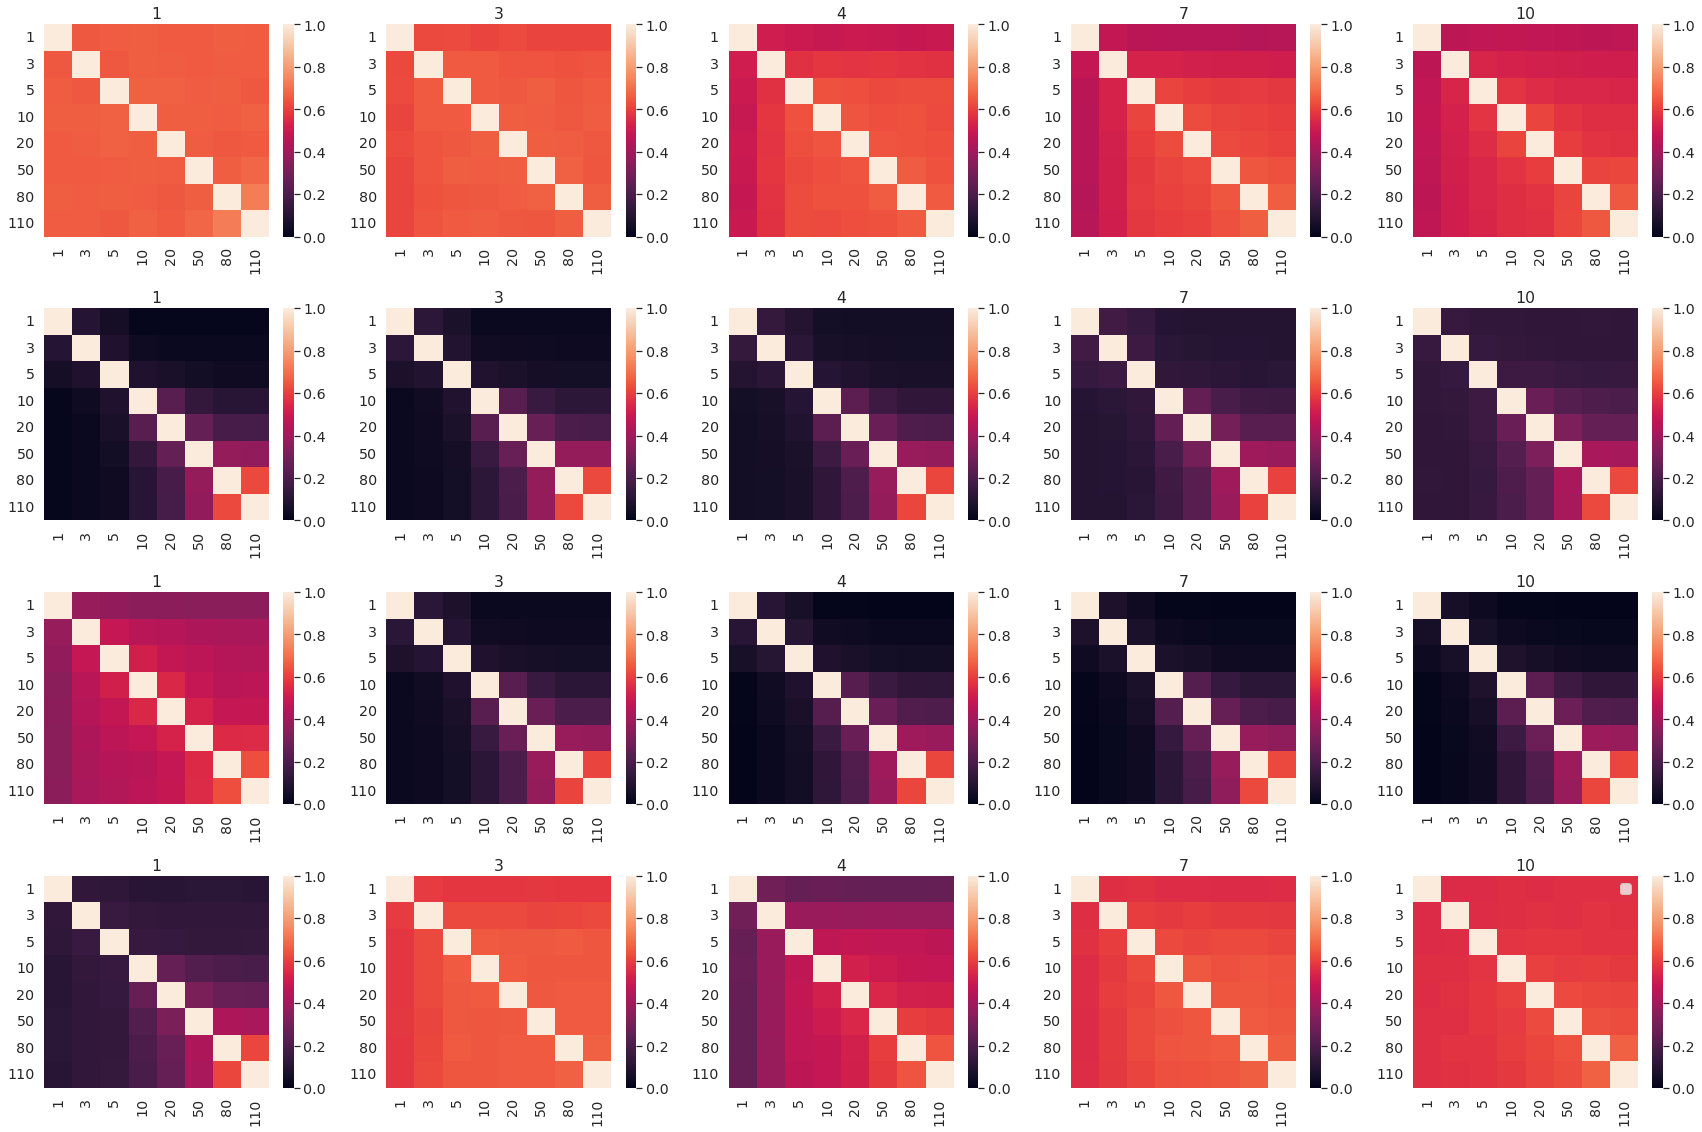

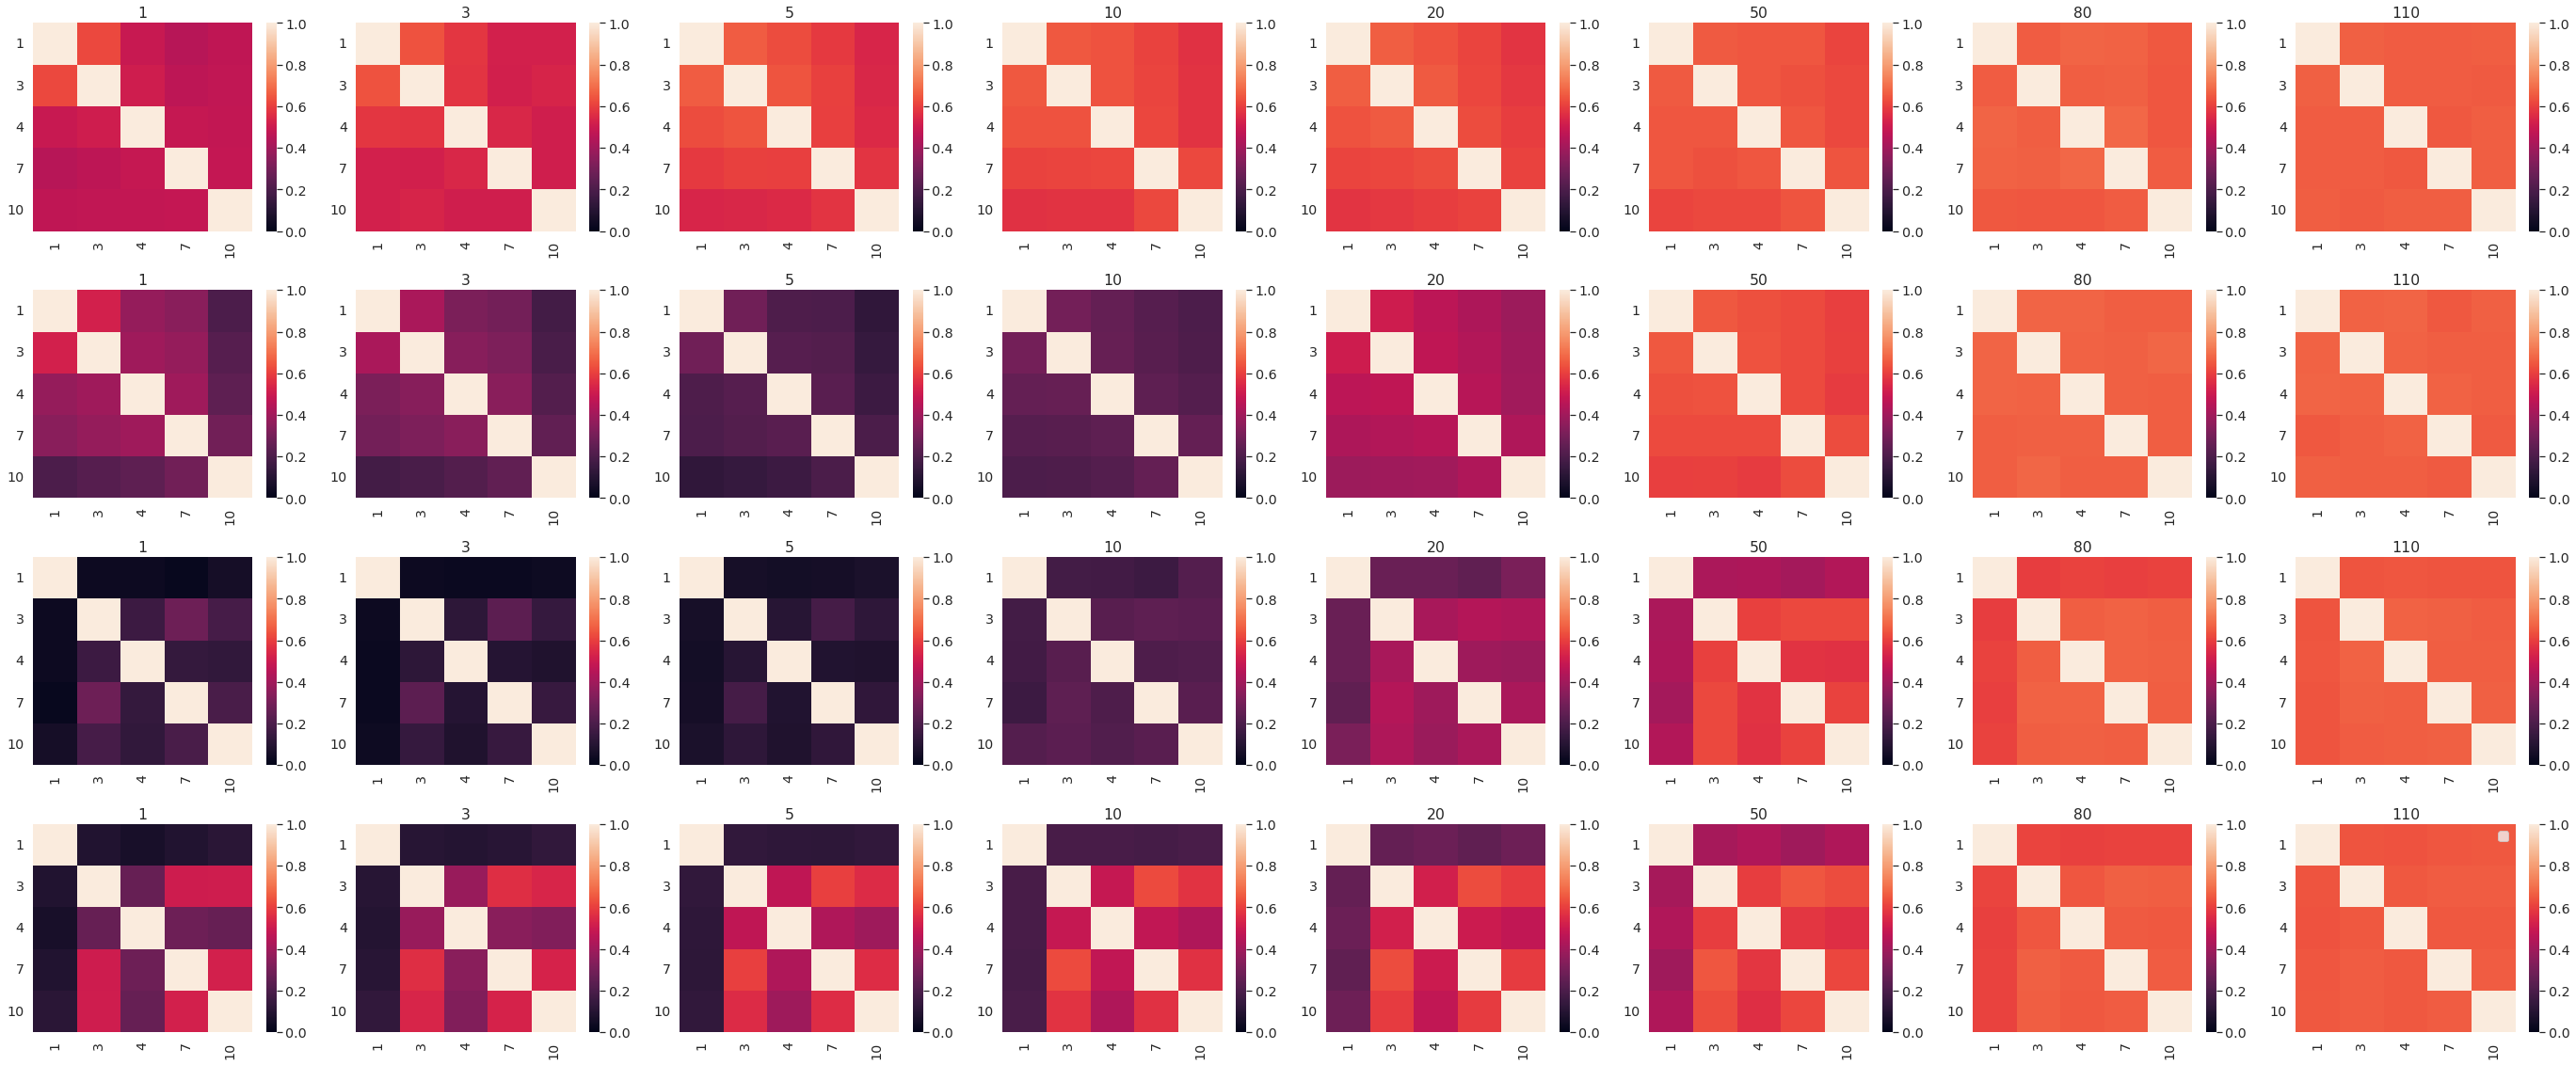

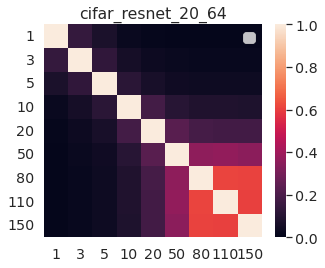

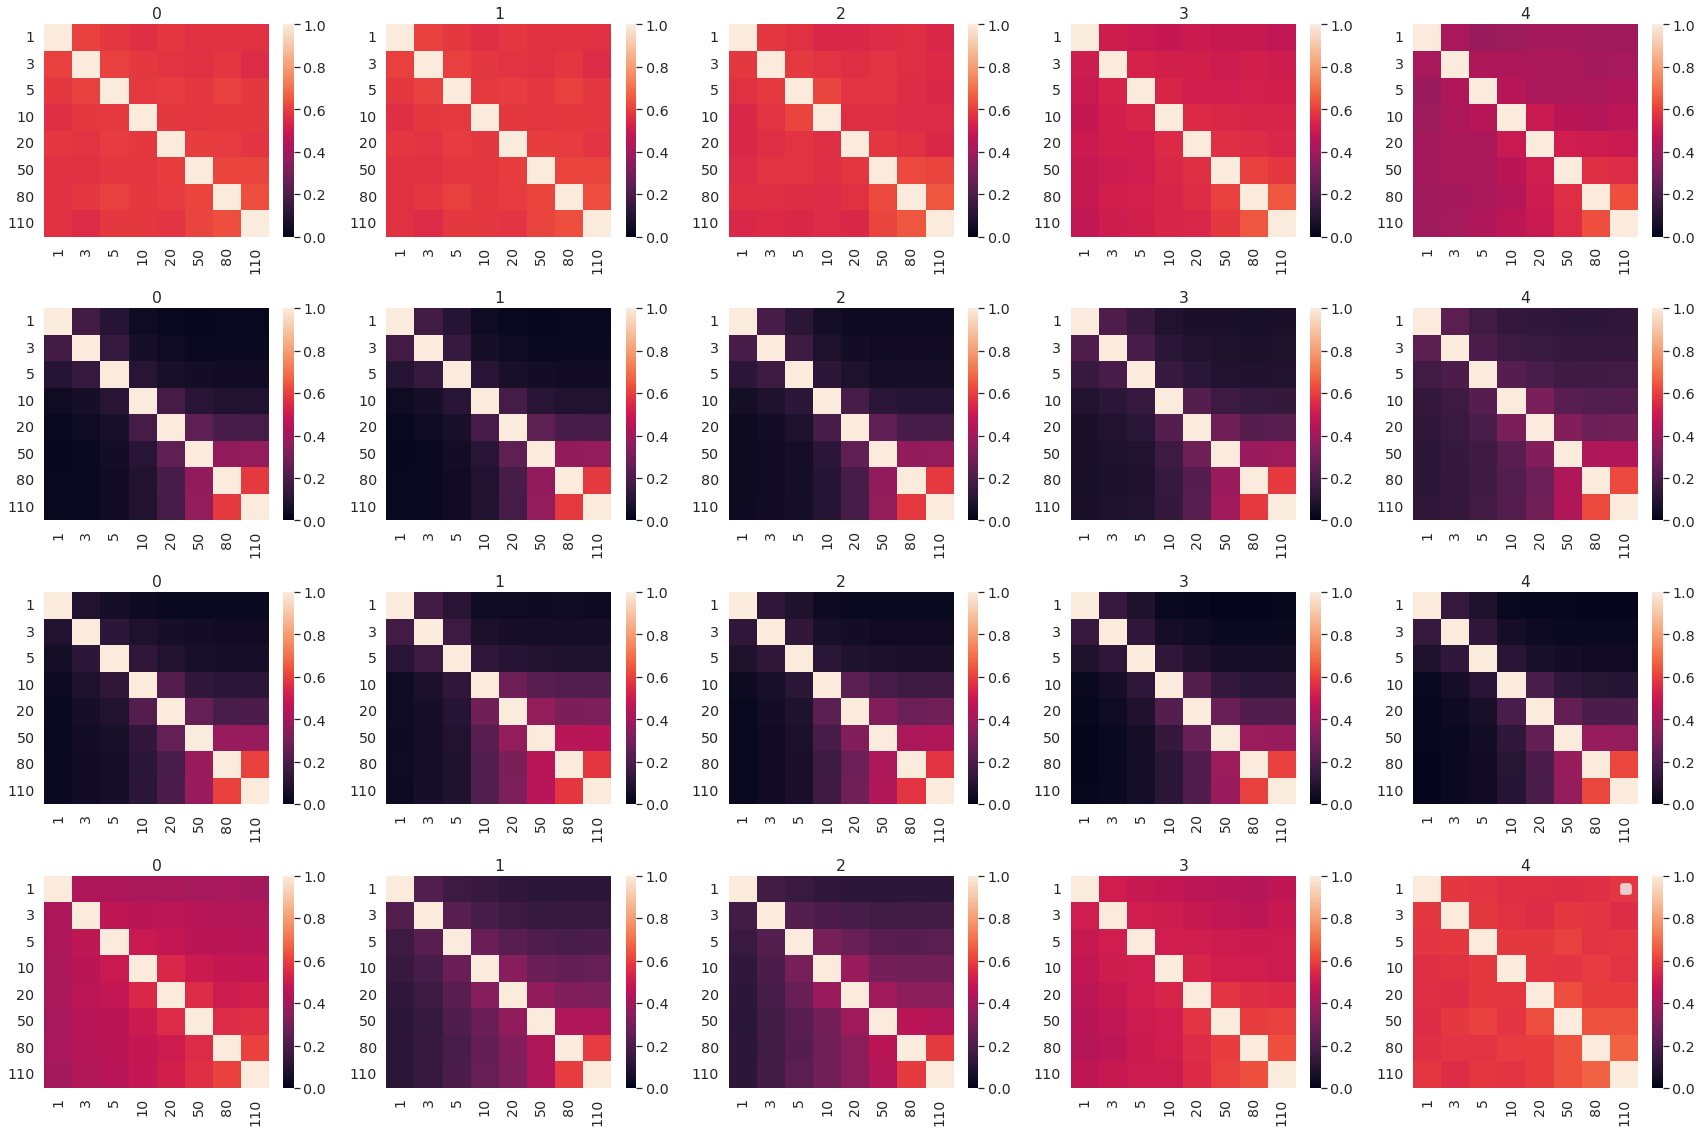

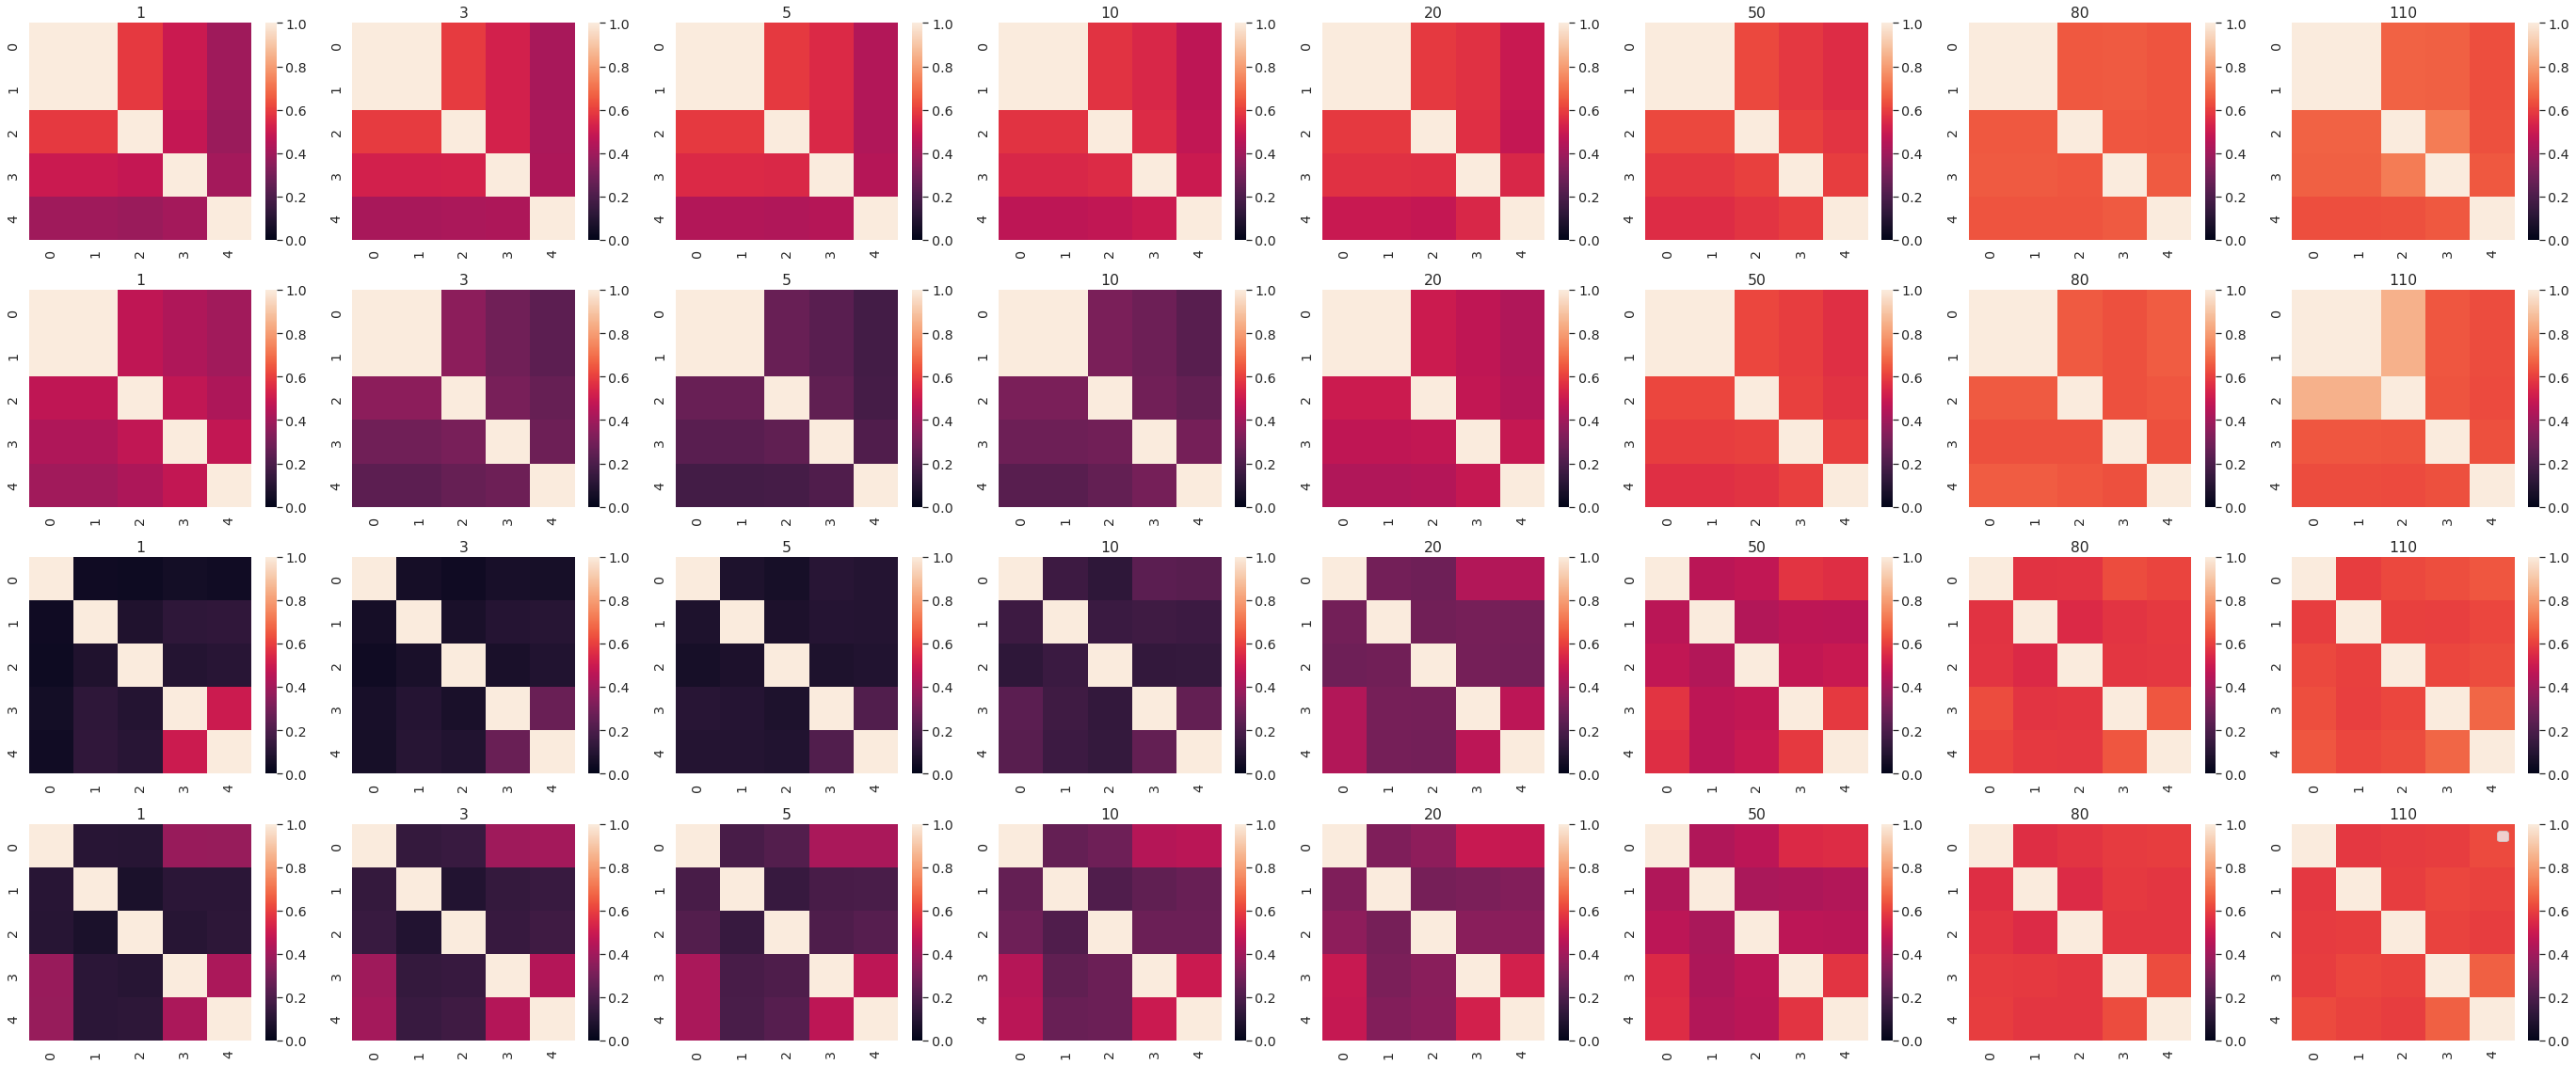

In [4]:
def plot_pairwise_fixed_points(ax, model, idx, sort_by_epoch=True):
    if sort_by_epoch:
        sort_by = np.array([int(Path(x).stem.split("-")[2].split("_")[0][2:]) for x in perm_files[model][idx]])
    else:
        sort_by = np.array([int(Path(x).stem.split("-")[-1]) for x in perm_files[model][idx]])
    sort_idx = np.argsort(sort_by)
    idx = idx[sort_idx]
    sns.heatmap(averaged_fps[model][idx][:, idx], xticklabels=sort_by[sort_idx], yticklabels=sort_by[sort_idx], ax=ax, vmin=0, vmax=1)

def plot_all_layersplit(model, sort_by_epoch=False):
    if sort_by_epoch:
        cols = all_thresholds[model]
    else:
        cols = all_perm_epochs[:-1]
    fig, axes = plt.subplots(4, len(cols), figsize=(len(cols)*1, 4))
    for row, type in zip(axes, ["bottom-up", "top-down", "leave-out", "put-in"]):
        for ax, col, in zip(row, cols):
            ax.set_title(col)
            if sort_by_epoch:
                idx = np.where([type in x and f"-{col}.pt" in x for x in perm_files[model]])[0]
            else:
                idx = np.where([type in x and f"ep{col}_" in x for x in perm_files[model]])[0]
            plot_pairwise_fixed_points(ax, model, idx, sort_by_epoch=sort_by_epoch)
    finalize_plot(fig, shape=(len(cols)*1.2, 4))

for model in models.values():
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    p_t_idx = np.where(["ckpt" in x or "final" in x for x in perm_files[model]])[0]
    plot_pairwise_fixed_points(ax, model, p_t_idx)
    ax.set_title(model)
    finalize_plot(fig, shape=(1.2, 1))
    plot_all_layersplit(model, True)
    plot_all_layersplit(model, False)

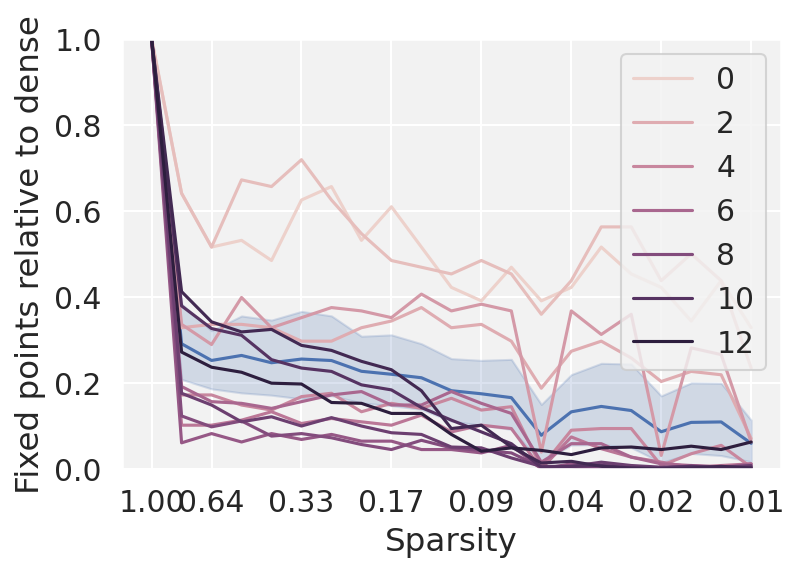

In [44]:
# plot average proportion of fixed points (y-axis) per model (lines)
# between P_150 (final-all) and P_t (ckpt-none), (t is x-axis)
# baseline is between P_150 and no perm (identity-all)
fig, ax = plt.subplots(1,  1, figsize=(6, 4), dpi=150)
sns.lineplot(df, x="level", y="fixed_points")
ax.set_ylim(0., 1.)
ax.set_ylabel("Fixed points relative to dense")
ax.set_xlabel("Sparsity")
xticks = [0] + list(range(2, 21, 3))
ax.set_xticks(xticks)
ax.set_xticklabels([f"{0.8**x:0.2f}" for x in xticks])
sns.lineplot(df, x="level", y="fixed_points", hue="layer")
fig = finalize_plot(fig, shape=(1.4, 1))
plt.savefig("../figures/fixed-points-dense-vs-sparse.pdf")